<a href="https://colab.research.google.com/github/VarvarKs/Few-shot-annotation/blob/main/Neologism_detected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Краткое описание задачи

Разметка датасета для дальнейшего использования полученных классов в спел-чекере/дообучения NER модели

# Исходные данные

In [ ]:
import pandas as pd
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# файл включает слова, которые не внесены в словарь ОРФО
data = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/words_inc_230524.txt", sep='\t', encoding='utf-16')
data.head()


,N,Log,W,Dict_UD,dict.opcorpora,wiki_freq
0,367.0,-3.817249,хз,NaN,NaN,24
1,488.0,-3.909896,чо,NOUN an,"PRCL Infr,Dist",351
2,538.0,-3.939917,зп,NaN,NaN,18
3,540.0,-3.940406,пикабу,NaN,NaN,NaN
4,579.0,-3.963836,как-будто,NaN,NaN,19


In [ ]:
# слова, которые не знает ОРФО
vocab_inc = set(data['W'].dropna())
print(f"""Всего {len(vocab_inc)} неизвестных слов, например такие {list(vocab_inc)[:10]}.""")

# для баланса добавим правильные слова
data2 = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/words_cor_230603.txt", sep='\t',  encoding='utf-8')
vocab_cor = set(data2['W'].dropna())
print(f"""Всего {len(vocab_cor)} известных слов, например такие {list(vocab_cor)[:10]}.""")



Всего 168936 неизвестных слов, например такие ['явин', 'питрс', 'перлифонов', 'киналева', 'тюленчиком', 'бритков', 'балыгин', 'большиства', 'дрочибельный', 'коновалев'].
Всего 349943 известных слов, например такие ['запариться', 'еженедельная', 'стокгольма', 'билета', 'росреестр', 'бельма', 'тыкнете', 'признавать', 'подчинить', 'гришелева'].


С пропоцией данных можно эксперементировать:

для тестовой выборки **test_data** - пока сделаю 80% ошибочных слов (8000 токенов), 20% правильных (2000 токенов), так как фокус именно на разметку слов, которые ОРФО не знает.

для контрольной выборки можно сделать выбрать из этих групп по 10%

In [ ]:
test_inc = list(vocab_inc)[:8000]
test_inc_to_annotate = list(test_inc[:800])

test_cor = list(vocab_cor)[:2000]
test_cor_to_annotate = list(test_cor[:200])

test_data = test_inc + test_cor
test_to_annotate = test_inc_to_annotate + test_cor_to_annotate

In [ ]:
vocab_inc_new = [w for w in list(vocab_inc) if w not in test_data]
vocab_cor_new = [w for w in list(vocab_cor) if w not in test_data]

In [ ]:
test_inc2 = list(vocab_inc_new)[:8000]
test_cor2 = list(vocab_cor_new)[:2000]
test_data2 = test_inc2 + test_cor2

In [ ]:
with open('test_to_annotate.txt', 'w') as file:
    file.write("\n".join(test_to_annotate))

#Тестируем готовые модели NER



[Здесь](https://t.me/natural_language_processing) набралась идей.


1.   Spacy
2.   DeepPavlov
3.   pullenti
4.   stanza
5.   Natasha
6.   [Проект RuNNE](https://github.com/bond005/runne_contrastive_ner)


Говорят, пункты 1-3 так себе работают из коробки. Про п.4 ничего не слышала раньше. П.5 решает проблему Nested named entity recognition -- для моей задачи не так актуально.

## Spacy NER

In [ ]:
import spacy
! python -m spacy download ru_core_news_sm

In [ ]:
nlp = spacy.load("ru_core_news_sm")
text = 'серпуховчаночка'
doc = nlp(text)

for ent in doc.ents:
  print(ent.label_)

In [ ]:
nlp = spacy.load("ru_core_news_sm")

ent_dict = {'word': ['entity']}
#тут на NA не проверила
for word in tqdm(list(vocab)):
  if type(word) is not str:
    continue
  else:
    doc = nlp(word)
    for ent in doc.ents:
      ent_dict[ent.text] = [ent.label_]

df = pd.DataFrame.from_dict(ent_dict, orient='index')
print(df)

In [ ]:
df[1:].sort_index(inplace=True)
df.to_csv("/content/drive/MyDrive/NLP_spring2023/spacy_ner230524.txt", encoding='utf-8', sep="\t", index=True, header=False)

In [ ]:
spacy_df = pd.read_csv('/content/drive/MyDrive/NLP_spring2023/spacy_ner230524.txt', sep='\t')
spacy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30585 entries, 0 to 30584
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    30585 non-null  object
 1   entity  30585 non-null  object
dtypes: object(2)
memory usage: 478.0+ KB


In [ ]:
spacy_words = set(spacy_df['word'])
spacy_ner = (spacy_df['word'], spacy_df['entity'])
spacy_ner_df = pd.DataFrame(spacy_ner)
spacy_ner_df = spacy_ner_df.T
spacy_ner_df.head()

,word,entity
0,шаипова,PER
1,капайкин,PER
2,труфкакин,PER
3,смученкова,PER
4,шибрина,PER


In [ ]:
leftover = []
for word in vocab:
  if word not in spacy_words:
    leftover.append((word, 'O'))
spacy_lo_df = pd.DataFrame(leftover)
spacy_lo_df = spacy_lo_df.rename(columns ={0: 'word', 1: 'entity'})
spacy_lo_df.shape

(138374, 2)

In [ ]:
from sklearn.utils import shuffle

spacy_total_df = pd.concat([spacy_lo_df, spacy_ner_df])
spacy_total_df = shuffle(spacy_total_df)
spacy_total_df.head()
#spacy_total_df.to_csv("/content/drive/MyDrive/NLP_spring2023/spacy_total230524.txt", encoding='utf-8', sep="\t", index=False, header=True)

,word,entity
8648,ноль-семьдесят,O
132525,присандалить,O
130609,едганов,O
5949,хрдиректоров,PER
126856,шеринговой,O


In [ ]:
print(f"NER results:\
        entities:{spacy_total_df.shape[0] - spacy_total_df.loc[spacy_total_df['entity'] == 'O'].shape[0]}\
        non-recognized words:{spacy_total_df.loc[spacy_total_df['entity'] == 'O'].shape[0]}")

NER results:        entities:30585        non-recognized words:138374


Уже сейчас видно, что многие фамилии проигнорированы)

`!!!! распредление, визуал (для R)`

## [DeepPavlov NER ](https://docs.deeppavlov.ai/en/master/features/models/NER.html)



In [ ]:
!pip install -q deeppavlov
!python -m deeppavlov install ner_ontonotes_bert_torch


In [ ]:
from deeppavlov import build_model

ner_model = build_model('ner_ontonotes_bert_torch', download=True, install=True)

In [ ]:
ner_model(['серпуховчаночка'])

In [ ]:
vocab_list = list(vocab)
ent_dict = {'word': ['entity']}

for i in tqdm(range(len(vocab_list))):
  n = ner_model([vocab_list[i]])
  n = [l[0] for l in n]
  ent_dict[n[0][0]] = [n[1][0]]
ent_dict
df = pd.DataFrame.from_dict(ent_dict, orient='index')
df

In [ ]:
df[1:].sort_index(inplace=True)
df.to_csv("/content/drive/MyDrive/NLP_spring2023/deeppavlov_ner230524.txt", encoding='utf-8', sep="\t", index=True, header=False)

In [ ]:
import pandas as pd

deepp_df = pd.read_csv('/content/drive/MyDrive/NLP_spring2023/deeppavlov_ner230524.txt', sep='\t')
print(f"NER results:\
        entities: {deepp_df.shape[0] - deepp_df.loc[deepp_df['entity'] == 'O'].shape[0]}\
        non-recognized words: {deepp_df.loc[deepp_df['entity'] == 'O'].shape[0]}")

NER results:        entities: 104365        non-recognized words: 62800


In [ ]:
deepp_df.loc[deepp_df['entity'] == 'O']

,word,entity
2,спту,O
7,иэсджи,O
10,пошучено,O
11,электриество,O
13,опеатоа,O
...,...,...
167156,ще,O
167159,супергероики,O
167161,чероке,O
167162,активо,O


In [ ]:
deepp_df.loc[deepp_df['entity'] == 'O'].to_csv("/content/drive/MyDrive/NLP_spring2023/deeppavlov_O.txt", encoding='utf-8', sep="\t", index=False, header=True)

`!!!! распредление, визуал (для R)`

## [Natasha](https://github.com/natasha/natasha)

In [ ]:
! pip install natasha

In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [ ]:
ent_dict = {'word': ['entity']}

for word in tqdm(list(vocab)):
  text = word
  doc =(Doc(text))
  doc.segment(segmenter)
  doc.tag_ner(ner_tagger)
  if doc.spans:
    ent_dict[text] = [list(doc.spans[0])[2]]

df = pd.DataFrame.from_dict(ent_dict, orient='index')
print(df)

In [ ]:
text = 'Мария'
doc =(Doc(text))
doc.segment(segmenter)
doc.tag_ner(ner_tagger)
list(doc.spans[0])[2]


Остальные



*   [pullenti](https://www.pullenti.ru/Document)

Отдельная [версия](https://github.com/pullenti/pullenti-wrapper) под питон не обновляется. Это вообще что-то совсем сложное -- трогать его не буду

*   stanza

Ничего вообще толкового не определяет


## **Вывод**

DeepPavlov NER выделил намного больше сущностей.**

Ложные срабатывания есть (примеры):
```
разницой	B-PERSON
эфайэф	B-PERSON
лотерейки	B-PERSON
злобненький	B-GPE
```

# Используем ChatGPT для разметки данных

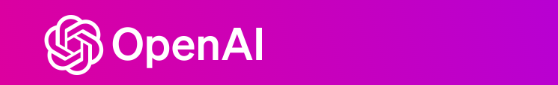

Основная информация взята из этого курса по [промпт-инжинирингу](https://www.deeplearning.ai/short-courses/chatgpt-prompt-engineering-for-developers/
), *важные рекоммендации получены из самого ChatGPT*

## Brief instruction by ChatGPT



1. Prepare the list: Compile the long list of words that you want ChatGPT to
label. Make sure the list is in a format that is easily readable and understandable by the model. **You can store the words in a text file or create a Python list or any other suitable format.**

2. Define your instructions: Clearly define the instructions you want to provide to ChatGPT for labeling the words. This could include **specific categories or labels you want to assign to the words, guidelines for how to handle ambiguous cases, or any other relevant instructions.**

3. Format your input: To communicate with ChatGPT, you'll need to format your input as a prompt. **Begin with a clear instruction or question to set the context**, and then include the relevant list of words.



**The OpenAI API only accepts text as input**, so you need to convert the contents of the CSV file into a suitable format for ChatGPT.

* Read the CSV file

* Extract the relevant data: Determine the specific data from the CSV file that you want to send to ChatGPT. It could be a single column or multiple columns depending on your requirements.

* Format the data: Format the extracted data into a suitable format for ChatGPT. Typically, this involves converting the data into a text string that you can include as part of your prompt. You might concatenate the values from each row or format them in a way that aligns with your instruction.

* Construct the prompt: Create a prompt that includes the necessary instructions and the formatted data from the CSV file. Make sure the prompt is clear and provides sufficient context for ChatGPT to understand what you are asking.

* Interact with the API: Use the OpenAI API to send your prompt and receive the model's response. You can make an API call with your prompt as the input and receive the generated text as the output.

4. Interact with ChatGPT: Use an API or interface that allows you to interact with the ChatGPT model. You can make API calls if an API is available, or use an SDK provided by OpenAI. Pass your formatted input as the prompt and receive the model's response.

5. Iterate if needed: If the model's labeling doesn't meet your expectations or if it requires clarification, you can iterate the process by refining your instructions, adjusting the input format, or providing more context to the model. By experimenting and refining your prompts, you can improve the accuracy of the model's labeling.

**It's important to note that the OpenAI API has limitations on the maximum token count (e.g., 4096 tokens for GPT-3.5 models)**. If your CSV file is too large to fit within this limit, you will need to truncate or reduce the data accordingly or split it into multiple requests.

## ChatGPT API Setup

In [ ]:
!pip install openai
!pip install pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import openai
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai.api_key  = <API_KEY>

In [ ]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

## Готовим данные
Нужно вручную собрать по 10-30 примеров каждой из групп для промптов

Решено выделить семь групп сущностей:

```
NEW - neologisms
ORG - organisations, companies, apps
SLN - slang
NORM - normal (dictionary) words
ERR - misspelled words
PER - people, surnames
GEO - geopolitical entities
```



In [ ]:
import pandas as pd
examples = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/Examples_for_prompt.txt", encoding='utf-8', sep='\t')
examples

,word,tag
0,блеваь,ERR
1,асроиь,ERR
2,предсталяю,ERR
3,коньюнктуру,ERR
4,атмосфэра,ERR
...,...,...
119,тамбове,GPE
120,уктус,GPE
121,шарташ,GPE
122,стенфордского,GPE


In [ ]:
errors = list(examples.loc[examples['tag'] == 'ERR']['word'])[:7]
print(*errors, sep=', ')

блеваь, асроиь, предсталяю, коньюнктуру, атмосфэра, комерческий, обязаа


In [ ]:
neologisms = list(examples.loc[examples['tag'] == 'NEW']['word'])[:7]
slang = list(examples.loc[examples['tag'] == 'SLN']['word'])[:7]
person_names = list(examples.loc[examples['tag'] == 'PER']['word'])[:7]
companies = list(examples.loc[examples['tag'] == 'ORG']['word'])[:7]
normal_words = list(examples.loc[examples['tag'] == 'NORM']['word'])[:7]
geo = list(examples.loc[examples['tag'] == 'GPE']['word'])[:7]

In [ ]:
normal_words

['брюнетка',
 'будильники',
 'бульоном',
 'заглядывали',
 'загнивающий',
 'кондитерские',
 'ною']

In [ ]:
# a fragment of the set of all words to label
import random

test_data = []
with open ("/content/drive/MyDrive/NLP_spring2023/test_data.txt", encoding='utf-8') as file:
  for line in file:
      test_data.append(line.strip('\n'))
random.shuffle(test_data)
print(len(test_data), test_data[:10], sep='\n')

10000
['прилюдии', 'анальнят', 'сэкаритис', 'полыхнул', 'абмакина', 'клевикова', 'шавернев', 'дучева', 'лемесов', 'кум']


In [ ]:
groups_specifications = f"""Groups description, examples and tag:
1. Neologisms, occasional words, ```{neologisms}```, NEW
2. Organisations, companies, apps, ```{companies}```, ORG
3. Slang and swear words, ```{slang}```, SLN
4. Normal correct words, ```{normal_words}```, NORM
5. Misspelled, incorrect words, ```{errors}```, ERR
6. Surnames, ```{person_names}```, PER
7. Cities and countries, ```{geo}```, GEO"""

### Промпты 1

In [ ]:
prompt = f"""
Your task is to determine which NER group  Russian word should be and label the
word with the group tag.

Do the classificasion based on ```{groups_specifications}```
The list of Russian words to label: ```{test}```
"""
response = get_completion(prompt)
print(response)

дурнайкин - PER
шаришься - SLN
утепков - PER
антифрод-системе - ORG
апосталова - PER
борзелков - PER
каналюги - PER
кабанцов - PER
руснова - PER
приучивают - NORM
мамулов - PER
цыгвинцев - PER
сигуткин - PER
ебаного - SLN
йопте - SLN
нахимин - PER
доконца - NORM
фотай - NORM
настояшие - NORM
кракозяброй - ERR
плвать - ERR
айти-компаний - ORG
эффекивноси - ERR
шлипаков - PER
будетвы - NORM
рогелева - PER
малинычев - PER
зулина - PER
ехнологий - NORM
класики - NORM
эйденом - PER
уёбываться - SLN
моисейкин - PER
фазульянов - PER
пристройством - NORM
мацилецкая - PER
балко - PER
шапулин - PER
шашлык-машлык - NORM
баракеев - PER
спижжены - SLN
фелодипин - NORM
аляуданова - PER
коласкова - PER
мтодами - ERR
постящий - NORM
блекберри - NORM
шакалистый - SLN
сувирова - PER
цигин - PER
оркской - GEO
месам - NORM
литвицкая - PER
андрова - PER
долбоёбства - SLN
сагалин - GEO
рализацию - NORM
попо - SLN
гипрок - NORM
тожероссиянами - NORM
вчера-позавчера - NORM
аренки - NORM
доебывал - SLN
успли -

In [ ]:
prompt = f"""
Your task is to determine which NER group  Russian word should be and label the
word with the group tag.

Do the classificasion based on ```{groups_specifications}```
The list of Russian words to label: ```{test}```

Put them to ```{result}```, key=word, value = tag
"""
response = get_completion(prompt)
print(response)

{
    'дурнайкин': 'PER',
    'шаришься': 'SLN',
    'утепков': 'PER',
    'антифрод-системе': 'ORG',
    'апосталова': 'PER',
    'борзелков': 'PER',
    'каналюги': 'PER',
    'кабанцов': 'PER',
    'руснова': 'PER',
    'приучивают': 'NORM',
    'мамулов': 'PER',
    'цыгвинцев': 'PER',
    'сигуткин': 'PER',
    'ебаного': 'SLN',
    'йопте': 'SLN',
    'нахимин': 'PER',
    'доконца': 'NORM',
    'фотай': 'NORM',
    'настояшие': 'NORM',
    'кракозяброй': 'ERR',
    'плвать': 'ERR',
    'айти-компаний': 'ORG',
    'эффекивноси': 'ERR',
    'шлипаков': 'PER',
    'будетвы': 'NORM',
    'рогелева': 'PER',
    'малинычев': 'PER',
    'зулина': 'PER',
    'ехнологий': 'ERR',
    'класики': 'NORM',
    'эйденом': 'PER',
    'уёбываться': 'SLN',
    'моисейкин': 'PER',
    'фазульянов': 'PER',
    'пристройством': 'NORM',
    'мацилецкая': 'PER',
    'балко': 'NORM',
    'шапулин': 'PER',
    'шашлык-машлык': 'NORM',
    'баракеев': 'PER',
    'спижжены': 'SLN',
    'фелодипин': 'NORM'

In [ ]:
result = response
type(result)

str

In [ ]:
prompt = f"""
Your task is to determine which NER group  Russian word should be and label the
word with the group tag.

Do the classificasion based on ```{groups_specifications}```
The list of Russian words to label: ```{test}```

Provide them in JSON format with the following keys: word, entity
"""
response = get_completion(prompt)
print(response)

[
  {"word": "банерами", "entity": "NORM"},
  {"word": "цедрик", "entity": "NORM"},
  {"word": "знакомст", "entity": "ERR"},
  {"word": "хуиная", "entity": "SLN"},
  {"word": "боченкова", "entity": "PER"},
  {"word": "джизья", "entity": "NORM"},
  {"word": "сайах", "entity": "NORM"},
  {"word": "восторгова", "entity": "PER"},
  {"word": "годинов", "entity": "NORM"},
  {"word": "ррпк", "entity": "ORG"},
  {"word": "бойзами", "entity": "NORM"},
  {"word": "скурпулезно", "entity": "NORM"},
  {"word": "удака", "entity": "SLN"},
  {"word": "хогбены", "entity": "NORM"},
  {"word": "обавки", "entity": "NORM"},
  {"word": "неканона", "entity": "NORM"},
  {"word": "пепекин", "entity": "ERR"},
  {"word": "избуцкая", "entity": "PER"},
  {"word": "пайбактова", "entity": "PER"},
  {"word": "законопроек", "entity": "NORM"},
  {"word": "чулеева", "entity": "PER"},
  {"word": "гринфилдбанка", "entity": "ORG"},
  {"word": "сорк", "entity": "NORM"},
  {"word": "городнева", "entity": "PER"},
  {"word": "

In [ ]:
prompt = f"""
Your task is to determine which NER group  Russian word should be and label the
word with the group tag.

Do the classificasion based on ```{groups_specifications}```
The list of Russian words to label: ```{test}```

Note that misspelled or imposible words like 'говноа' or 'сайах' should be
in errors with tag ERR
"""
response = get_completion(prompt)
print(response)

1. NORM - банерами, годинов, удака, добавки, неканона, пепекин, тупежа, олко, басик, секонд, настальгии, длинки, располагае, дифавтомат, три-в, сгнобить, пшиканья, напизди, биквин, лядских, месенджер
2. PER - Боченкова, Чулеева, Городнева, Тыричева, Щеверова, Понтягин, Баскина, Шальская, Махренова
3. GEO - Тамбове, Уктус, Шарташ, Ростову
4. ORG - Векторстройфинанс, Сбермаркетом, Минкомсвязью, Эхомосквы, Главпродукт, Гринфилдбанка
5. NEW - Роадмап, Фактчекинг, Нагенерировать, Карусельки, Укропропаганду
6. SLN - Ссыкливые, Пиздострадальцы, Сайэнтифик, Видюхи, Пидр, Хуиная, Говноа, Напизди
7. ERR - Цедрик, Знакомст, Джизья, Сайах, Восторгова, Ррпк, Бойзами, Скурпулезно, Хогбены, Законопроек, Изволинина, Зажопинсках, Мандавошку, Забыва, Современых, Прихренел, Двоешников, Амбюшуры, Ьей, Крысом, Незная, Ощные, Вонка, Аллика, Шеткин, Импакт-фактор, Сосаго, Кадамшоева, Безкультурие, Бахлинова, Шевенев, Шмин, Комладова, Итресурсов, Генаров, Накрячат, Кривашкина, Чайзер, Чекалкин.


In [ ]:
prompt = f"""
Your task is to determine which NER group  Russian word should be and label the
word with the group tag.

Do the classificasion based on ```{groups_specifications}```
The list of Russian words to label: ```{test}```

Note that misspelled or imposible words like 'говноа' or 'сайах' should be
in errors with tag ERR.

Present results in the list format
"""
response = get_completion(prompt)
print(response)

['банерами', NORM], ['цедрик', NORM], ['знакомст', NORM], ['хуиная', SLN], ['боченкова', PER], ['джизья', NORM], ['сайах', ERR], ['восторгова', PER], ['годинов', NORM], ['ррпк', ORG], ['бойзами', NORM], ['скурпулезно', NORM], ['удака', NORM], ['хогбены', NORM], ['обавки', NORM], ['неканона', NORM], ['пепекин', GEO], ['избуцкая', GEO], ['пайбактова', PER], ['законопроек', NORM], ['чулеева', PER], ['гринфилдбанка', ORG], ['сорк', NORM], ['городнева', PER], ['зажопинсках', ERR], ['мандавошку', ERR], ['забыва', NORM], ['мукасеева', PER], ['стрикс', NORM], ['говноа', ERR], ['тыричева', PER], ['червяцов', PER], ['тупежа', NORM], ['кугарова', PER], ['олко', NORM], ['басик', NORM], ['лэндкрузер', NORM], ['мде', SLN], ['нетесина', PER], ['змагарами', NORM], ['бичковская', PER], ['изволинина', PER], ['тепереча', GEO], ['коюшева', PER], ['биотеха', NORM], ['ховинская', GEO], ['понторезом', NORM], ['асоскова', PER], ['современых', ERR], ['прихренел', SLN], ['двоешников', NORM], ['амбюшуры', NORM],

In [ ]:
type(response)

str

'знакомст', NORM

### Промпты 2

In [ ]:
prompt = f"""
Your task is to determine which NER group  Russian word should be and label the
word with the group tag.

Do the classificasion based on ```{groups_specifications}```
The list of Russian words to label: ```{test}```

Note that misspelled or imposible words like 'говноа' or 'сайах' should be
in errors with tag ERR,

Present results in csv format
"""
response = get_completion(prompt)
print(response)

кундозеров, PER
вредоноса, NORM
нечяева, PER
менячкин, PER
хикку, NEW
стонякина, PER
бались, NORM
отарбиев, PER
кумер, NORM
зафейлилась, NEW
талмачева, PER
бармоткин, PER
сусляева, PER
сунгатулин, PER
корешева, PER
ельфимова, PER
беберина, PER
тулпечкина, PER
ит-специалисты, ORG
нэвэльного, NEW
янчуркина, PER
мяснянкин, PER
шляпнуков, PER
маж, NORM
отшельниченко, PER
ведомоство, ORG
литышев, PER
выпускае, ERR
раекории, NORM
кураколов, PER
трансгендерных, NEW
нигерши, SLN
масленный, NORM
рибанова, PER
спотифае, ORG
борачев, PER
балева, PER
трощина, NORM
сеньером, PER
толобанова, PER
рейвенора, PER
триллиард, NEW
болтачев, PER
мемяца, NORM
жд, NORM
разроднова, PER
шулыгин, PER
мудорисова, PER
милипиздрической, SLN
никогла, ERR
кск, ORG
випрвпн, NEW
ослопова, PER
трамантина, PER
молинова, PER
катинов, PER
оч-чень, NEW
неиллюзорно, NORM
писюша, SLN
валодя, PER
пациорина, PER
макдакам, ORG
иина, PER
волотеева, PER
мусарне, NORM
филюткин, PER
чамакова, PER
утяткина, PER
медпред, ORG
голодало

In [ ]:
with open('new_text.txt', 'w') as file:
    file.write(response)

In [ ]:
prompt = f"""Why have you decided that хикку,NEW
пидут,SLN
ведомоство,ORG"""
response = get_completion(prompt)
print(response)

As an AI language model, I do not have personal preferences or decisions. However, I can provide some information about the words you mentioned:

- Хикку (Hikikomori) is a Japanese term used to describe people who withdraw from society and isolate themselves in their homes for an extended period.
- Пидут (Pidut) is a Ukrainian word that means "they go" in English.
- SLN is an abbreviation that can stand for different things depending on the context. It could refer to a Slovakian airline company, a Swedish law firm, or a medical term for a type of skin lesion called seborrheic keratosis.
- Ведомоство (Vedomstvo) is a Russian word that means "government agency" or "department" in English.


In [ ]:
prompt = f"""why did you decide that according to ```{groups_specifications}```
'ведомоство' has 'ORG' tag? Is it a correct word?"""
response = get_completion(prompt)
print(response)

Yes, "ведомоство" can be considered a correct word and it would have the "ORG" tag as it refers to an organization or government agency.


In [ ]:
prompt = f"""why did you decide that according to ```{groups_specifications}```
'ведомоство' has 'ORG' tag? The word is misspelled, the correct variant is 'ведомство'. What tag to use?"""
response = get_completion(prompt)
print(response)

The correct tag for 'ведомство' would be NORM, as it is a normal (dictionary) word.


In [ ]:
prompt = f"""why did you decide that according to ```{groups_specifications}```
'ведомоство' has 'ORG' tag? The word is misspelled, the correct variant is 'ведомство'. What tag to use for 'ведомоство'?"""
response = get_completion(prompt)
print(response)

The correct tag for 'ведомоство' would be ERR, as it is a misspelled word.


In [ ]:
prompt = f"""
Your task is to determine which NER group  Russian word should be and label the
word with the group tag.

Do the classificasion based on ```{groups_specifications}```
The list of Russian words to label: ```{test}```

Pay close attention to misspelled or imposible words like 'говноа', 'сайах' and
'ведомоство', they should be in errors with tag ERR,

Present results in csv format with '\t' separator
"""
response = get_completion(prompt)
print(response)

кундозеров	PER
вредоноса	ERR
нечяева	PER
менячкин	PER
хикку	SLN
стонякина	PER
бались	SLN
отарбиев	PER
кумер	SLN
зафейлилась	ERR
талмачева	PER
бармоткин	PER
сусляева	PER
сунгатулин	PER
корешева	PER
ельфимова	PER
беберина	PER
тулпечкина	PER
ит-специалисты	ORG
нэвэльного	NEW
янчуркина	PER
мяснянкин	PER
шляпнуков	PER
маж	SLN
отшельниченко	PER
ведомоство	ERR
литышев	PER
выпускае	ERR
раекории	ERR
кураколов	PER
трансгендерных	SLN
нигерши	SLN
масленный	PER
рибанова	PER
спотифае	ORG
борачев	PER
балева	PER
трощина	PER
сеньером	PER
толобанова	PER
рейвенора	PER
триллиард	NEW
болтачев	PER
мемяца	PER
жд	GEO
разроднова	PER
шулыгин	PER
мудорисова	PER
милипиздрической	SLN
никогла	SLN
кск	ORG
випрвпн	ORG
ослопова	PER
трамантина	PER
молинова	PER
катинов	PER
оч-чень	SLN
неиллюзорно	SLN
писюша	SLN
валодя	PER
пациорина	PER
макдакам	ORG
иина	PER
волотеева	PER
мусарне	PER
филюткин	PER
чамакова	PER
утяткина	PER
медпред	ORG
голодалов	PER
чигиркин	PER
стативкина	PER
бибашова	PER
джелялов	PER
подевятов	PER
долбан

In [ ]:
with open('second_prompt.txt', 'w') as file:
    file.write(response)

Различия между первым и вторым промптом
~~~
вредоноса	NORM | ERR Correct
хикку	NEW | SLN Correct
бались	NORM | SLN Incorrect (ERR)
кумер	NORM | SLN Correct
зафейлилась	NEW | ERR Incorrect (SLN)
маж	NORM | SLN Incorrect (ERR)
ведомоство	ORG | ERR Correct
раекории	NORM | ERR Correct
трансгендерных	NEW | SLN Incorrect (NORM)
масленный	NORM | PER Incorrect (ERR)
трощина	NORM | PER Correct
мемяца	NORM | PER Incorrect (ERR)
жд	NORM | GEO
никогла	ERR | SLN Incorrect (ERR)
випрвпн	NEW | ORG Correct
оч-чень	NEW | SLN Incorrect (ERR)
неиллюзорно	NORM | SLN Incorrect (NORM)
мусарне	NORM | PER Incorrect (SLN)
дороговасто	NEW | SLN Correct
страновой	NORM | GEO Incorrect (NORM)
~~~
Различия ровно на 20%, при изменении промпта качество улучшилось (7 правильных, 3 правильных изменены на неправильные)

In [ ]:
prompt = f"""
Your task is to determine which NER group  Russian word should be and label the
word with the group tag.

Do the classificasion based on ```{groups_specifications}```
The list of Russian words to label: ```{test}```

Pay close attention to errors (ERR), they include:
- misspelled 'сайах', 'ведомоство'
- imposible Russian words like 'мемяца', 'никогла'
- grammatically incorrect like 'масленный'
- words with unnecessary hyphen.

Present results in csv format with '\t' separator
"""
response2 = get_completion(prompt)
print(response2)

кундозеров	PER
вредоноса	ERR
нечяева	PER
менячкин	PER
хикку	ERR
стонякина	PER
бались	ERR
отарбиев	PER
кумер	ERR
зафейлилась	ERR
талмачева	PER
бармоткин	PER
сусляева	PER
сунгатулин	PER
корешева	PER
ельфимова	PER
беберина	PER
тулпечкина	PER
ит-специалисты	ORG
нэвэльного	ERR
янчуркина	PER
мяснянкин	PER
шляпнуков	PER
маж	ERR
отшельниченко	PER
ведомоство	ERR
литышев	PER
выпускае	ERR
раекории	ERR
кураколов	PER
трансгендерных	ERR
нигерши	ERR
масленный	ERR
рибанова	PER
спотифае	ERR
борачев	PER
балева	PER
трощина	PER
сеньером	PER
толобанова	PER
рейвенора	PER
триллиард	NEW
болтачев	PER
мемяца	ERR
жд	ERR
разроднова	PER
шулыгин	PER
мудорисова	PER
милипиздрической	ERR
никогла	ERR
кск	ORG
випрвпн	ORG
ослопова	PER
трамантина	PER
молинова	PER
катинов	PER
оч-чень	ERR
неиллюзорно	ERR
писюша	ERR
валодя	PER
пациорина	PER
макдакам	ORG
иина	PER
волотеева	PER
мусарне	ERR
филюткин	PER
чамакова	PER
утяткина	PER
медпред	ORG
голодалов	PER
чигиркин	PER
стативкина	PER
бибашова	PER
джелялов	PER
подевятов	PER
долбан

In [ ]:
with open('third_prompt.txt', 'w') as file:
    file.write(response2)

Различия со вторым промптом, явный перевес в сторону ERR, в ущерб SLN
~~~
хикку	SLN | ERR (both are possible)
бались	SLN | ERR Correct
кумер	SLN | ERR (both are possible)
нэвэльного	NEW | ERR (both are possible)
маж	SLN | ERR Correct
трансгендерных	SLN | ERR Incorrect (NORM)
нигерши	SLN | ERR Incorrect (SLN) -
масленный	PER | ERR Correct
спотифае	ORG | ERR Incorrect (ORG) -
мемяца	PER | ERR Correct
жд	GEO ERR Incorrect (NORM)
милипиздрической	SLN | ERR Incorrect (SLN) -
никогла	SLN | ERR Correct
оч-чень	SLN | ERR Correct
неиллюзорно	SLN | ERR Incorrect (NORM)
писюша	SLN | ERR Incorrect (SLN) -
мусарне	PER | ERR Incorrect (SLN)
долбанулись	SLN | ERR Incorrect (SLN) -
ушатывает	SLN | ERR Incorrect (SLN) -
дрищом	SLN | ERR Incorrect (SLN) -
дороговасто	SLN | ERR (both are possible)
пидут	SLN | ERR Correct
страновой	GEO | ERR Incorrect (NORM)
~~~
Разница >20%, ложные срабатывания на сленг

In [ ]:
prompt = f"""
Your task is to determine which NER group  Russian word should be and label the
word with the group tag.

Do the classificasion based on ```{groups_specifications}```
The list of Russian words to label: ```{test}```

Pay close attention to errors (ERR), they include:
- misspelled 'сайах', 'ведомоство'
- imposible Russian words like 'мемяца', 'никогла'
- incorrect like 'масленный'
- words with unnecessary hyphen.

Present results in csv format with '\t' separator
"""
response3 = get_completion(prompt)
print(response3)

кундозеров	NORM
вредоноса	NORM
нечяева	PER
менячкин	NORM
хикку	NEW
стонякина	PER
бались	NORM
отарбиев	PER
кумер	NORM
зафейлилась	ERR
талмачева	PER
бармоткин	NORM
сусляева	PER
сунгатулин	PER
корешева	PER
ельфимова	PER
беберина	PER
тулпечкина	PER
ит-специалисты	ORG
нэвэльного	NEW
янчуркина	PER
мяснянкин	NORM
шляпнуков	NORM
маж	NORM
отшельниченко	PER
ведомоство	ERR
литышев	PER
выпускае	ERR
раекории	NORM
кураколов	NORM
трансгендерных	NORM
нигерши	NORM
масленный	ERR
рибанова	PER
спотифае	NORM
борачев	PER
балева	PER
трощина	NORM
сеньером	NORM
толобанова	PER
рейвенора	NORM
триллиард	NORM
болтачев	PER
мемяца	ERR
жд	NORM
разроднова	PER
шулыгин	NORM
мудорисова	PER
милипиздрической	NORM
никогла	ERR
кск	ORG
випрвпн	ORG
ослопова	PER
трамантина	PER
молинова	PER
катинов	PER
оч-чень	NORM
неиллюзорно	NORM
писюша	NORM
валодя	NORM
пациорина	PER
макдакам	NORM
иина	PER
волотеева	PER
мусарне	NORM
филюткин	PER
чамакова	PER
утяткина	PER
медпред	NORM
голодалов	NORM
чигиркин	PER
стативкина	PER
бибашова	PER
джел

In [ ]:
with open('4_prompt.txt', 'w') as file:
    file.write(response3)

*Далее будто запомнив мои запросы, проставила больше 30% норм. Меняю фрагмент датасета*


In [ ]:
prompt = f"""
Your task is to determine which NER group  Russian word should be and label the
word with the group tag.

Do the classificasion based on ```{groups_specifications}```
The list of Russian words to label: ```{test}```

Pay close attention to errors (ERR), they include:
- misspelled 'сайах', 'ведомоство'
- imposible Russian words like 'мемяца', 'никогла'
- words with unnecessary hyphen.

Present results in csv format with '\t' separator
"""
response4 = get_completion(prompt)
print(response4)

сорвис	NEW
топлеса	NORM
ссдшник	NEW
ешком	NORM
теребинин	PER
клепач	NORM
пелагеина	PER
бэ-мэ	NEW
гильда	NORM
адоньева	PER
заебательская	SLN
гавротина	NORM
дечева	PER
бесяво	NORM
кирдяпин	PER
дахрена	SLN
многоходовочка	NORM
уебал	SLN
жополиз	SLN
трокаев	PER
некритин	SLN
битюжов	PER
свидомые	SLN
тавокин	PER
заволокина	PER
пишишь	NORM
демьянкова	PER
агресии	SLN
партократия	NORM
пентакс	NORM
нафасова	PER
кримиал	ERR
базельцев	PER
лимасуева	PER
бабанкина	PER
хаммонда	PER
трапезин	NORM
килачков	PER
морехина	PER
матейкина	PER
шарвина	PER
райффайзенбанку	ORG
кормазова	PER
лобышова	PER
влазил	NORM
вадимка	PER
джпег	NEW
маничкин	PER
гарена	NORM
митаева	PER
халяльную	NORM
тегин	PER
маджахедов	PER
драь	ERR
тройнева	PER
поцу	NORM
китнецов	PER
риходит	NORM
минифутбола	NORM
томишова	PER
бяшарова	PER
обьёмом	ERR
хуярил	SLN
непаханное	NORM
залупинск	ERR
условок	NORM
ксеноса	PER
векличева	PER
званникова	PER
тусич	PER
войдешкин	PER
клюткова	PER
настоенный	NORM
ильягуев	PER
салуянова	PER
срадаю	SLN
сиванк

In [ ]:
with open('4_prompt.txt', 'w') as file:
    file.write(response4)

### Цикл для прохода по всему датасету (Промпты 3)

In [ ]:
#  40 раз по 250 слов

beginning = 0
end = 250
for i in tqdm(range(1, 41)):
  test = test_data[beginning:end]
  prompt = f"""
  Your task is to determine which NER group  Russian word should be and label the
  word with the group tag.

  Do the classificasion based on ```{groups_specifications}```
  The list of Russian words to label: ```{test}```

  Pay close attention to errors (ERR), they include:
  - misspelled 'сайах', 'ведомоство'
  - imposible Russian words like 'мемяца', 'никогла'
  - words with unnecessary hyphen.

  Present results in csv format with '\t' separator
  """
  response = get_completion(prompt)
  with open('test_results.txt', 'a') as file:
    file.write(response)

  beginning += 250
  end += 250
print('Done!')

100%|██████████| 40/40 [34:11<00:00, 51.29s/it]

Done!


In [ ]:
# 40 раз по 250 слов

for n in range(1,4):
  beginning = 0
  end = 250
  for i in tqdm(range(1, 41)):
    test = test_data[beginning:end]
    prompt = f"""
    Your task is to determine which NER group  Russian word should be and label the
    word with the group tag.

    Do the classificasion based on ```{groups_specifications}```
    The list of Russian words to label: ```{test}```

    Pay close attention to errors (ERR), they include:
    - misspelled 'сайах', 'ведомоство'
    - imposible Russian words like 'мемяца', 'никогла'
    - words with unnecessary hyphen.

    Present results in csv format with '\t' separator
    """
    response = get_completion(prompt)
    with open('test_results' +str(n) + '.txt', 'a') as file:
      file.write(response)

    beginning += 250
    end += 250
print('     Done!')

100%|██████████| 40/40 [29:01<00:00, 43.53s/it]

     Done!


In [ ]:
beginning = 0
end = 250
for i in tqdm(range(1, 41)):
  test = test_data[beginning:end]
  prompt = f"""
  Your task is to determine which NER group Russian word should be and label each
  word with the group tag.

  Do the classificasion based on ```{groups_specifications}```
  The list of Russian words to label: ```{test}```

  Pay close attention to errors (ERR), they include:
  - misspelled 'сайах', 'ведомоство'
  - imposible Russian words like 'мемяца', 'никогла'
  - words with unnecessary hyphen.

  Do not skip a word.
  Present results in csv format with '\t' separator
  """
  response = get_completion(prompt)
  with open('test_results5.txt', 'a') as file:
    file.write(response)

  beginning += 250
  end += 250
print('Done!')

100%|██████████| 40/40 [23:14<00:00, 34.86s/it]

Done!


Нашла вот такой [ресурс](https://zvukibukvy.ru/slang) со сленгом, сайт можно спарсить

# Анализируем результаты пяти циклов

Цель -- найти закономерности, визуализировать распределение по классам, выбрать для каждого слова (статистически) наиболее вероятный тег

Файлы не в идеальном формате -- где-то сдвинуто форматирование (потеряна разметка)
~~~
страданиями	Sотогреется	NORM
~~~

Возможны галлюцинации
~~~
хапанули	VERB
~~~

In [ ]:
import pandas as pd
from tqdm import tqdm

res_one = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/test_results1.txt", encoding='utf-8', sep='\t')
res_two = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/test_results2.txt", encoding='utf-8', sep='\t')
res_three = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/test_results3.txt", encoding='utf-8', sep='\t')
res_four = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/test_results4.txt", encoding='utf-8', sep='\t')
res_five = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/test_results5.txt", encoding='utf-8', sep='\t')

res_one.rename(columns = {'Word':'word', 'Label':'label'}, inplace = True)
res_two.rename(columns = {'Word':'word', 'Label':'label'}, inplace = True)
res_three.rename(columns = {'Word':'word', 'Label':'label'}, inplace = True)
res_four.rename(columns = {'Word':'word', 'Label':'label'}, inplace = True)
res_five.rename(columns = {'Word':'word', 'Label':'label'}, inplace = True)

res_one.head()

,word,label
0,абаджев,PER
1,абанин,PER
2,абарисова,PER
3,абарыкова,PER
4,абгалин,PER


Word Overlap: Compare the overlap of words across the five dataframes. Identify common words that appear in all or most of the dataframes and explore their corresponding labels. This analysis can provide insights into the consistency or divergence of labels for frequently occurring words.

Label Distribution: Analyze the distribution of labels across the five dataframes. Identify the most common labels and observe any variations or similarities in their occurrence across the dataframes. This comparison can reveal patterns or discrepancies in labeling practices.

Label Agreement: Check for label agreement across the dataframes by comparing the labels assigned to the same word in each dataframe. Calculate inter-rater agreement metrics, such as Cohen's kappa or Fleiss' kappa, to assess the level of agreement among the dataframes' labeling. https://towardsdatascience.com/inter-rater-agreement-kappas-69cd8b91ff75

Label Co-occurrence: Investigate the co-occurrence patterns of labels within each dataframe. Identify pairs or groups of labels that tend to occur together more frequently than expected by chance. This analysis can reveal relationships between different labels and provide insights into potential labeling biases or patterns.

Label Consistency: Examine the consistency of labels within and across the dataframes for individual words. Check if there are any words that have inconsistent or contradictory labels across the dataframes. This comparison can highlight areas of disagreement or potential labeling errors that need further investigation.

### Word Overlap

Определим, какие слова попали во все датафреймы, посмотрим, какие у них теги, таким образом, поймем насколько последовательна разметка.

In [ ]:
common_words = set(res_one['word']).intersection(res_two['word'], res_three['word'], res_four['word'], res_five['word'])
print("Столько слов попали во все файлы: ", len(list(common_words)))

Столько слов попали во все файлы:  7002




> #### Только слова, попавшие во все выдачи



In [ ]:
l_of_words = []
for word in tqdm(common_words):
  l = [word]
  l.append(res_one.loc[res_one['word'] == word, 'label'].values[0])
  l.append(res_two.loc[res_two['word'] == word, 'label'].values[0])
  l.append(res_three.loc[res_three['word'] == word, 'label'].values[0])
  l.append(res_four.loc[res_four['word'] == word, 'label'].values[0])
  l.append(res_five.loc[res_five['word'] == word, 'label'].values[0])
  l_of_words.append(l)
df_label_per_word = pd.DataFrame(l_of_words, columns=['word', '1', '2', '3', '4', '5'])
df_label_per_word.sample()

100%|██████████| 7002/7002 [00:41<00:00, 167.03it/s]


,word,1,2,3,4,5
1390,бревенчатый,NORM,NORM,NORM,NORM,NORM


In [ ]:
equal_tags = []
diff_tags = []

for word in tqdm(common_words):
  l = [word]
  tag1 = res_one.loc[res_one['Word'] == word, 'Label'].values[0]
  tag2 = res_two.loc[res_two['Word'] == word, 'Label'].values[0]
  tag3 = res_three.loc[res_three['Word'] == word, 'Label'].values[0]
  tag4 = res_four.loc[res_four['Word'] == word, 'Label'].values[0]
  tag5 = res_five.loc[res_five['Word'] == word, 'Label'].values[0]
  l.append(tag1)
  l.append(tag2)
  l.append(tag3)
  l.append(tag4)
  l.append(tag5)

  if tag1 == tag2 == tag3 == tag4 == tag5:
    equal_tags.append((word, tag1))
  else:
    diff_tags.append(l)
df_equal_tags = pd.DataFrame(equal_tags, columns=['word', 'label'])
df_diff_tags = pd.DataFrame(diff_tags, columns=['word', '1', '2', '3', '4', '5'])
df_equal_tags.info()

100%|██████████| 7003/7003 [00:42<00:00, 163.76it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4148 entries, 0 to 4147
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    4148 non-null   object
 1   label   4148 non-null   object
dtypes: object(2)
memory usage: 64.9+ KB


**ИТОГО:** 4148 слов (59%), попавших во все выдачи, имеют одинаковые теги во всех случаях



> #### Все слова, которые были в тестовых данных



In [ ]:
#  сводная таблица: для каждого слова тег, если он есть в файле
test_data = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/test_data.txt", encoding='utf-8', sep='\t', names =['word', '1', '2', '3', '4', '5'])
df_test_data = test_data.sort_values('word')
df_test_data.reset_index(drop=True, inplace=True)

for i, row in tqdm(df_test_data.iterrows()):
  word = row['word']
  try:
    tag1 = res_one.loc[res_one['word'] == word, 'label'].values[0]
  except IndexError:
    continue
  df_test_data.loc[i, '1'] = tag1
  try:
    tag2 = res_two.loc[res_two['word'] == word, 'label'].values[0]
  except IndexError:
    continue
  df_test_data.loc[i, '2'] = tag2
  try:
    tag3 = res_three.loc[res_three['word'] == word, 'label'].values[0]
  except IndexError:
    continue
  df_test_data.loc[i, '3'] = tag3
  try:
    tag4 = res_four.loc[res_four['word'] == word, 'label'].values[0]
  except IndexError:
    continue
  df_test_data.loc[i, '4'] = tag4
  try:
    tag5 = res_five.loc[res_five['word'] == word, 'label'].values[0]
  except IndexError:
    continue
  df_test_data.loc[i, '5'] = tag5
df_test_data.info()

10000it [00:52, 191.30it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    10000 non-null  object
 1   1       8428 non-null   object
 2   2       8404 non-null   object
 3   3       8402 non-null   object
 4   4       8359 non-null   object
 5   5       7002 non-null   object
dtypes: object(6)
memory usage: 468.9+ KB


In [ ]:
#df_test_data.to_csv("df_test_data.txt", encoding='utf-8', sep="\t", index=False, header=True)

In [ ]:
# в трех, четырех или пяти случаях одинаковый тег

from itertools import permutations

all_tags = df_test_data.values.tolist()
best = []
for word in tqdm(all_tags):
  for i in list(set(permutations(word[1:], r=3))):
    if i[0] == i[1] == i[2]:
      best.append((word[0], i[0]))
df_best_tags = pd.DataFrame(best, columns=['word', 'label'])
df_best_tags.info()

100%|██████████| 10000/10000 [00:00<00:00, 111003.59it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8257 entries, 0 to 8256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    8257 non-null   object
 1   label   8257 non-null   object
dtypes: object(2)
memory usage: 129.1+ KB


In [ ]:
#df_best_tags.to_csv("test_result_tags.txt", encoding='utf-8', sep="\t", index=False, header=True)

**ИТОГО:** 6963 слова, имеющие одинаковые теги в большинстве случаев


## Распределение тегов
Графики из R

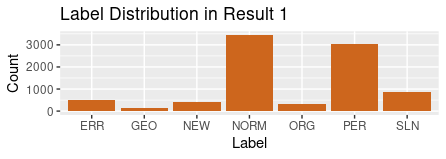
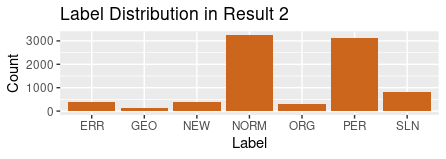
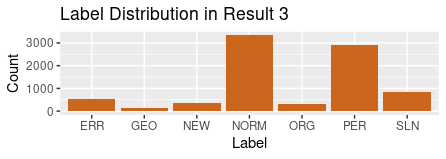
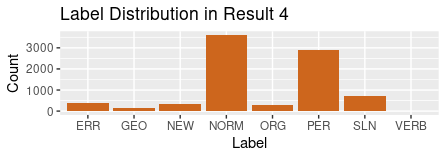
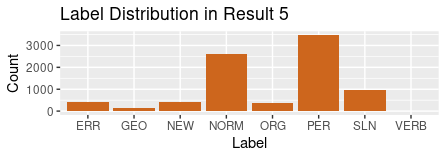

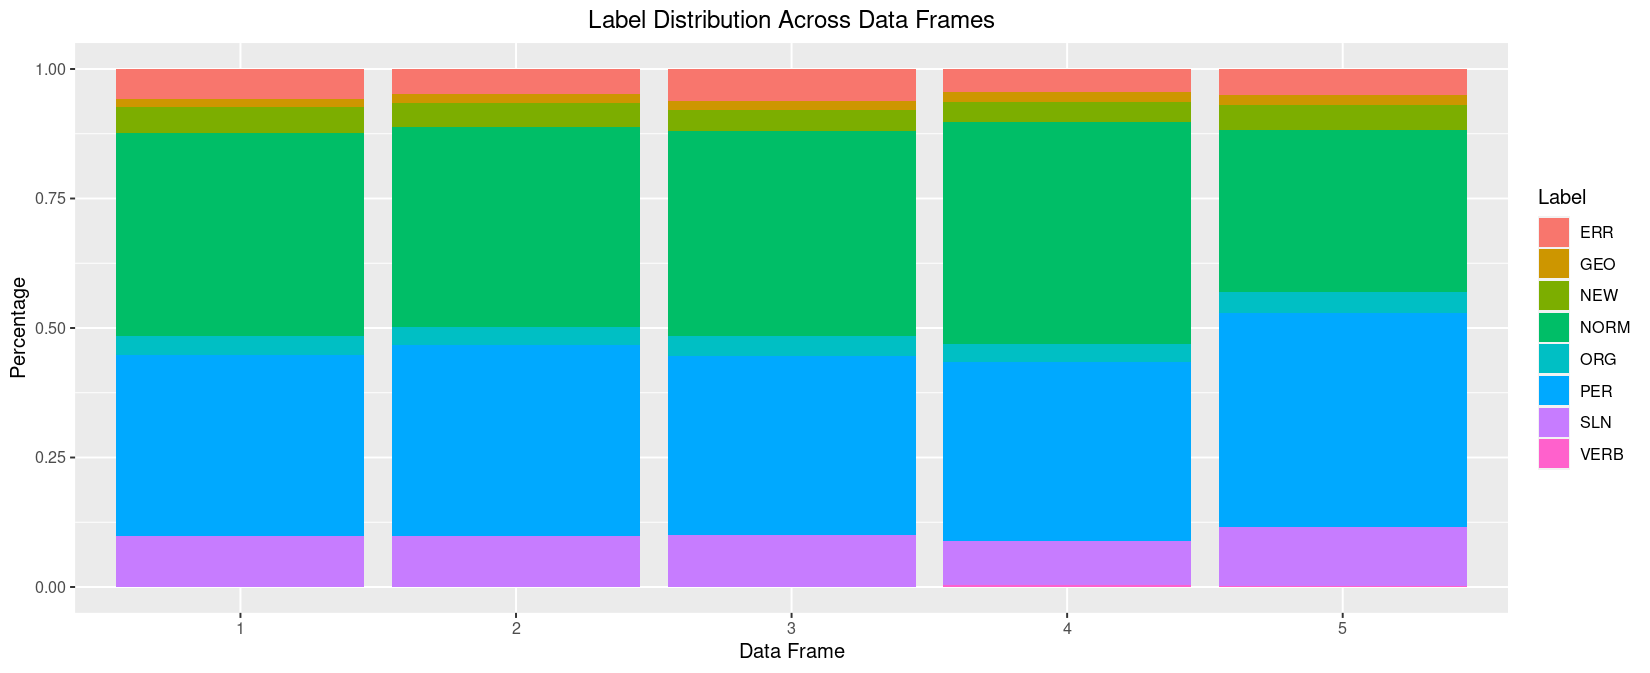

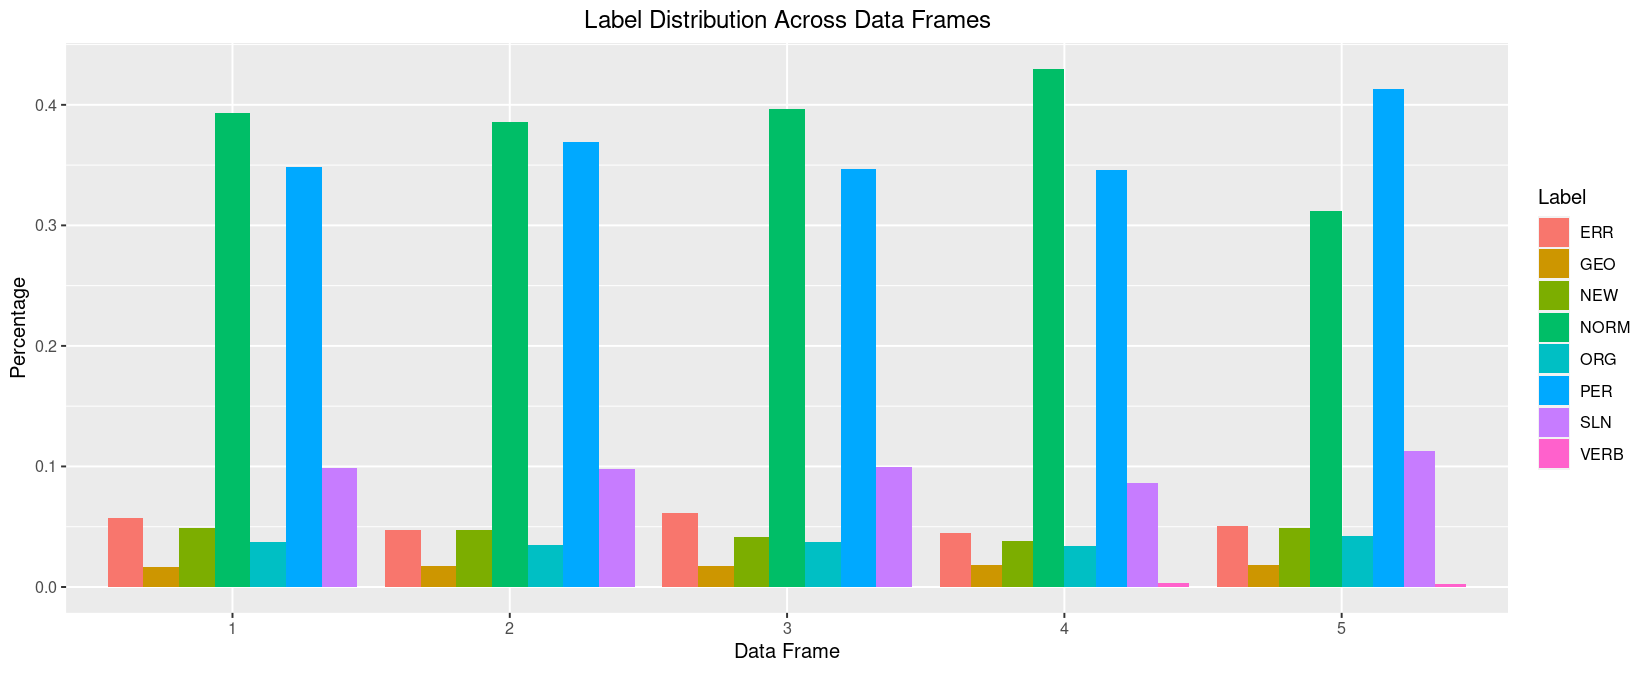

Можно сделать два основных вывода:

1.   Во всех прогонах получается довольно стабильное распределение по тегам
2.   В 4 и 5 прогоне возник тег VERB, которого не было в специализации; результаты этих прогонов резко отличаются от трех предыдущих (соотношение NORM/PER)



## Последовательность разметки первых трех иттераций

In [ ]:
common_words3 = set(res_one['word']).intersection(res_two['word'], res_three['word'])
print("Столько слов попали в первые три файла: ", len(list(common_words3)))

Столько слов попали в первые три файла:  8410


In [ ]:
equal_tags3 = []
diff_tags3 = []

common_words_with_tags3 = []
for word in tqdm(common_words3):
  l = [word]
  tag1 = res_one.loc[res_one['word'] == word, 'label'].values[0]
  tag2 = res_two.loc[res_two['word'] == word, 'label'].values[0]
  tag3 = res_three.loc[res_three['word'] == word, 'label'].values[0]

  l.append(tag1)
  l.append(tag2)
  l.append(tag3)

  common_words_with_tags3.append(l)

  if tag1 == tag2 == tag3:
    equal_tags3.append((word, tag1))
  else:
    diff_tags3.append(l)

common_words3_df = pd.DataFrame(common_words_with_tags3, columns=['word', 'r1', 'r2', 'r3'])

df_equal_tags3 = pd.DataFrame(equal_tags3, columns=['word', 'label'])
df_diff_tags3 = pd.DataFrame(diff_tags3, columns=['word', '1', '2', '3'])
df_equal_tags3.info()


100%|██████████| 8410/8410 [00:33<00:00, 248.00it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7777 entries, 0 to 7776
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    7777 non-null   object
 1   label   7777 non-null   object
dtypes: object(2)
memory usage: 121.6+ KB


**ИТОГО:** 7777 слов (92%), среди попавших в первые три выдачи, имеют
одинаковые теги во всех случаях

In [ ]:
common_words3_df.to_csv("common_words3_df.txt", encoding='utf-8', sep="\t", index=False, header=True)

In [ ]:
inconsistent_labels = []
for word in list(common_words3):
    labels = set(res_one[res_one['word'] == word]['label']).union(res_two[res_two['word'] == word]['label'],
                                                          res_three[res_three['word'] == word]['label'])
    if len(labels) > 1:
        inconsistent_labels.append((word, labels))
print(f"""Из {len(common_words3)} слов, попавших в первые три результата, {len(inconsistent_labels)} имеют отличную разметку ({len(inconsistent_labels)/len(common_words3) * 100}%)""")

Из 8410 слов, попавших в первые три результата, 683 имеют отличную разметку (8.12128418549346%)


## Согласованность разметки -- [коэффициент Каппа Коэна](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html)

Сравниваем теги, которые получило одно и то же слово во всех результатах

Посчитаем [коэффициент Каппа Коэна](https://towardsdatascience.com/inter-rater-agreement-kappas-69cd8b91ff75) -- оценку, которая выражает уровень согласия между двумя аннотаторами по проблеме классификации. ([на русском](https://runebook.dev/ru/docs/scikit_learn/modules/generated/sklearn.metrics.cohen_kappa_score))

In [ ]:
from sklearn.metrics import cohen_kappa_score
import pandas as pd

# соединяем датафреймы по слову
merged_df_1_2 = pd.merge(res_one, res_two, on='word', suffixes=('_1', '_2'))
merged_df_1_3 = pd.merge(res_one, res_three, on='word', suffixes=('_1', '_2'))
merged_df_2_3 = pd.merge(res_two, res_three, on='word', suffixes=('_1', '_2'))

kappa_score_1_2 = cohen_kappa_score(merged_df_1_2['label_1'], merged_df_1_2['label_2'])
kappa_score_1_3 = cohen_kappa_score(merged_df_1_3['label_1'], merged_df_1_3['label_2'])
kappa_score_2_3 = cohen_kappa_score(merged_df_2_3['label_1'], merged_df_2_3['label_2'])

print(f"""Kappa score для result1 and result2: {kappa_score_1_2}, \n
  для result1 и result3: {kappa_score_1_3}, \n
  для result2 и result3: {kappa_score_2_3}""")


Kappa score для result1 and result2: 0.8926768029577331, 

  для result1 и result3: 0.9309155201639149, 

  для result2 и result3: 0.9220555172532212


# Оценка результатов разметки

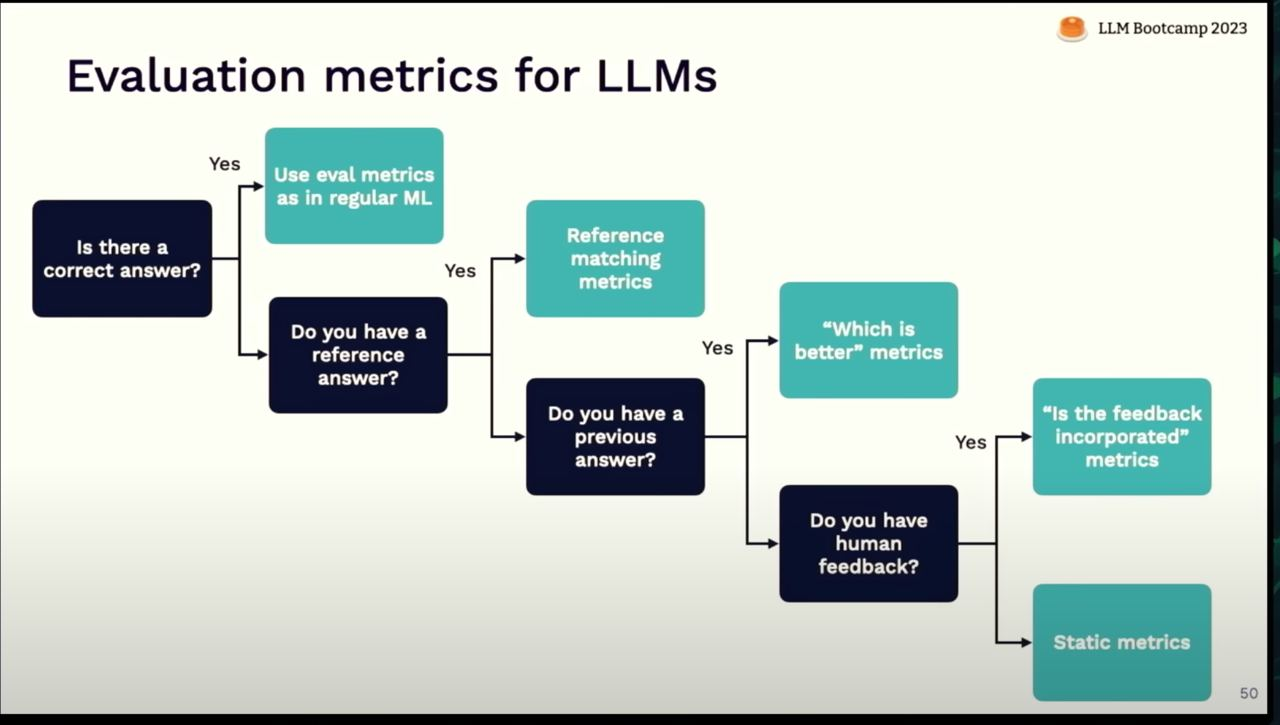

Так как для части данных есть ручная разметка, используем ее

## Cтандартные метрики (сравнение с золотым стандартом)
Используется только часть датасета, которая попала в ручную разметку


In [ ]:
annot_df = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/test_to_annotate.txt", encoding='utf-8', sep='\t')
annot_df.info

<bound method DataFrame.info of              word label
0           васик   PER
1       икеевской   ORG
2     пробухивали   SLN
3         знанияи   ERR
4        деникова   PER
..            ...   ...
995   коррелируют  NORM
996       пролезу  NORM
997  затянувшаяся  NORM
998      бумажным  NORM
999  подрощенного  NORM

[1000 rows x 2 columns]>

### Посмотрим на метрики для всех результатов

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns

def get_metrics(true_df, pred_df):
  words_true = list(true_df['word'])
  true = []
  pred = []
  for word in words_true:
    if word in list(pred_df['word']):
        true.append((word, list(true_df.loc[true_df['word'] == word, 'label'])[0]))
        pred.append((word, list(pred_df.loc[pred_df['word'] == word, 'label'])[0]))

  true.sort()
  pred.sort()
  y_true = [label for word, label in true]
  y_pred = [label for word, label in pred]

  #accuracy = accuracy_score(y_true, y_pred) - бесполезна, так как классы не сбалансированы
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')

  y_true = []
  y_pred = []


 # print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1)


In [ ]:
# по первому результату
get_metrics(annot_df, res_one)

Precision: 0.7289041085776147
Recall: 0.5816326530612245
F1-score: 0.6152328804191413


In [ ]:
# по второму результату
get_metrics(annot_df, res_two)

Precision: 0.776652933919023
Recall: 0.6134699853587116
F1-score: 0.6416417720112945


In [ ]:
# по третьему результату
get_metrics(annot_df, res_three)

Precision: 0.7454108827341409
Recall: 0.5841874084919473
F1-score: 0.6212690990053787


In [ ]:
# по четвертому результату
get_metrics(annot_df, res_four)

Precision: 0.7763223285260733
Recall: 0.5544117647058824
F1-score: 0.5996599646684928


In [ ]:
# по пятому результату
get_metrics(annot_df, res_five)

Precision: 0.751483595821248
Recall: 0.6373134328358209
F1-score: 0.6523915392332544


### Объединим в два класса: правильные и неправильные слова
Правильные -- все группы (NORM, PER, NEW, SLN, GEO)
Неправильные -- ERR и NA

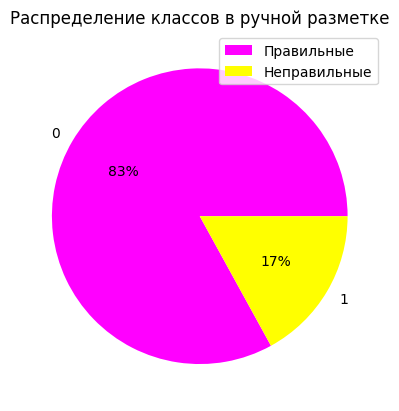

In [ ]:
import matplotlib.pyplot as plt

annot_df.loc[annot_df['label'] == 'ERR', 'label'] = 1
annot_df.loc[annot_df['label'] != 1, 'label'] = 0


classes = pd.value_counts(annot_df["label"]) # суммарный частотный словарь

classes.plot(kind = 'pie',  autopct='%0.f%%', colormap ='spring')

plt.title("Распределение классов в ручной разметке")

plt.ylabel('') # в пай чарте нет оси игрек

plt.legend( ['Правильные', 'Неправильные'], loc =0)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def get_bi_metrics(annot_df, res_one):
  # приведем к бинарному виду

  annot_df.loc[annot_df['label'] == 'ERR', 'label'] = 1
  annot_df.loc[annot_df['label'] != 1, 'label'] = 0

  res_one.loc[res_one['label'] == 'ERR', 'label'] = 1
  res_one.loc[res_one['label'] == 'NA', 'label'] = 1
  res_one.loc[res_one['label'] != 1, 'label'] = 0


  words_true = list(annot_df['word'])
  true = []
  pred = []
  for word in words_true:
    if word in list(res_one['word']):
        true.append((word, list(annot_df.loc[annot_df['word'] == word, 'label'])[0]))
        pred.append((word, list(res_one.loc[res_one['word'] == word, 'label'])[0]))
  true.sort()
  pred.sort()

  y_true = [label for word, label in true]
  y_pred = [label for word, label in pred]

  #accuracy = accuracy_score(y_true, y_pred) - бесполезна, так как классы не сбалансированы
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')


  cf_matrix = confusion_matrix(y_true, y_pred)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
  y_true = []
  y_pred = []

  #print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1)

Precision: 0.8260960208072362
Recall: 0.8228404099560761
F1-score: 0.7788255949034901


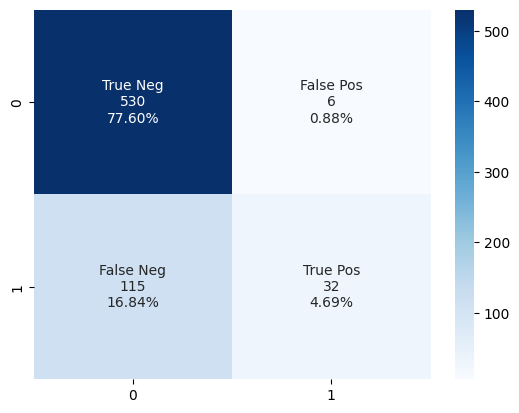

In [ ]:
# Метрики ВТОРОГО результата для бинарных классов
get_bi_metrics(annot_df, res_two)

Precision: 0.8297625617891251
Recall: 0.8328358208955224
F1-score: 0.7983166091738105


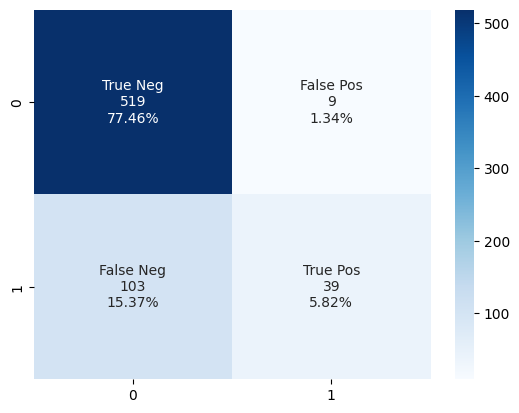

In [ ]:
# Метрики ПЯТОГО результата для бинарных классов
get_bi_metrics(annot_df, res_five)

In [ ]:
# Метрики первого результата для бинарных классов
get_bi_metrics(annot_df, res_one)

Precision: 0.7854934181464794
Recall: 0.8075801749271136
F1-score: 0.7666745998691021


In [ ]:
# Метрики третьего результата для бинарных классов
get_bi_metrics(annot_df, res_three)

Precision: 0.7871608823381647
Recall: 0.808199121522694
F1-score: 0.7681270938576886


In [ ]:
# Метрики четвертого результата для бинарных классов
get_bi_metrics(annot_df, res_four)

Precision: 0.8376624131221149
Recall: 0.8264705882352941
F1-score: 0.7827161299302329


# Еще одна попытка генерации

## Новый тестовый датасет

In [ ]:
import pandas as pd
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# файл включает слова, которые не внесены в словарь ОРФО
data = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/words_inc_230524.txt", sep='\t', encoding='utf-16')
# слова, которые не знает ОРФО
vocab_inc = set(data['W'].dropna())

# для баланса добавим правильные слова
data2 = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/words_cor_230603.txt", sep='\t',  encoding='utf-8')
vocab_cor = set(data2['W'].dropna())


In [ ]:
test_inc2 = list(vocab_inc)[:8000]
test_cor2 = list(vocab_cor)[:2000]

test_data2 = test_inc2 + test_cor2

with open('test_data2.txt', 'w') as file:
    file.write("\n".join(test_data2))


## Обновленный промпт

In [ ]:
from sklearn.utils import shuffle

examples = pd.read_csv("/content/drive/MyDrive/NLP_spring2023/Examples_for_prompt.txt", encoding='utf-8', sep='\t')
examples = shuffle(examples)
errors = list(examples.loc[examples['tag'] == 'ERR']['word'])[:7]
neologisms = list(examples.loc[examples['tag'] == 'NEW']['word'])[:7]
slang = list(examples.loc[examples['tag'] == 'SLN']['word'])[:7]
person_names = list(examples.loc[examples['tag'] == 'PER']['word'])[:7]
companies = list(examples.loc[examples['tag'] == 'ORG']['word'])[:7]
normal_words = list(examples.loc[examples['tag'] == 'NORM']['word'])[:7]
geo = list(examples.loc[examples['tag'] == 'GPE']['word'])[:7]
print(*neologisms)

актрисульки покупочку теребонькали суицидницы тугосерик пропутинская укропропаганду


In [ ]:
# a fragment of the set of all words to label
import random

test_data2 = []
with open ("/content/drive/MyDrive/NLP_spring2023/test_data_2.txt", encoding='utf-8') as file:
  for line in file:
      test_data2.append(line.strip('\n'))
random.shuffle(test_data2)
print(len(test_data2), test_data2[:10], sep='\n')

10000
['трусонюх', 'исправиь', 'паа', 'шокола', 'собачуля', 'мамыков', 'гаражника', 'кадмус', 'муталанова', 'мырза']


In [ ]:
groups_specifications = f"""Groups description, examples and tag:
1. Neologisms, occasional words, ```{neologisms}```, NEW
2. Organisations, companies, apps, ```{companies}```, ORG
3. Slang and swear words, ```{slang}```, SLN
4. Normal correct words, ```{normal_words}```, NORM
5. Misspelled, incorrect words, ```{errors}```, ERR
6. Surnames, ```{person_names}```, PER
7. Cities and countries, ```{geo}```, GEO"""

In [ ]:
test = test_data2[100:200]
prompt = f"""
  Your task is to classify every Russian word from the list and label each
  word with the group tag.

  Do the classificasion based on ```{groups_specifications}```, only the tags
  from specifications can be used.
  The list of Russian words to label: ```{test}```

  Pay close attention to errors (ERR), they include:
  - misspelled like 'сайах', 'могди'
  - imposible Russian words like 'мемяца', 'никогла'
  - words with unnecessary hyphen.

  Present results in csv format with '\t' separator
  """
response = get_completion(prompt)
print(response)

кайдинов	PER
столпаков	PER
йобу	SLN
бурдов	PER
гомбожапов	PER
могди	ERR
столькоже	NORM
остопиздела	SLN
пыринова	PER
оборачиваешь	NORM
ручёнки	NORM
горшинский	PER
бабышкина	PER
помошником	NORM
говнарем	SLN
отсыпной	NORM
требукова	PER
лемегов	PER
поделает	NORM
хмелинский	PER
производственный	NORM
казанбаева	PER
посткарантинного	NORM
кьюар	NEW
ахуенные	SLN
йии	SLN
откатики	NORM
покопайся	NORM
парилова	PER
эндера	PER
мобилизацию	NORM
был-не	ERR
збыковский	PER
мадилов	PER
поверина	NORM
куризов	PER
семенякина	PER
щепева	PER
кэто	ERR
синюхину	PER
галузов	PER
юридичской	NORM
инженеа	NORM
укуреные	SLN
буратина	PER
роана	PER
фрики	SLN
сознани	NORM
ложноположительных	NORM
жиа	PER
молдиндконбанк	ORG
лупцов	PER
звездочкин	PER
каргалев	PER
родственную	NORM
подъебы	SLN
гайбалиев	PER
бяу	ERR
культас	PER
вахтовке	NORM
прохоренко	PER
дём	NORM
силуков	PER
заменило	NORM
мудня	ERR
елынин	PER
порн	SLN
гапасов	PER
тайот	ORG
халкиопов	PER
патреон	ORG
роберта	PER
жестила	SLN
балко	PER
интеренета	ERR
пиарайэми	

## Проверка тегов

In [ ]:
prompt = f"""
  Your task is to classify every Russian word from the list and label each
  word with the group tag.

  According to ```{groups_specifications}``` which is better for the word
   'инженеа' tag 'NORM' or tag 'ERR'. Support your decision with the proof.
  """
response = get_completion(prompt)

In [ ]:
print(response)

Based on the information provided, it is likely that the word 'инженеа' should be tagged as 'ERR' for misspelled, incorrect words. This is because the word does not appear in any of the other categories and does not follow the spelling conventions of the Russian language. It is possible that the intended word was 'инженер' (engineer), which would fit into the 'NORM' category. However, without further context or information, it cannot be definitively determined which word was intended.


In [ ]:
prompt = f"""
  Your task is to classify every Russian word from the list and label each
  word with the group tag.

  According to ```{groups_specifications}``` which is better for the word
   'инженеа' tag 'SLN' or tag 'ERR'. Support your decision with the proof.
  """
response = get_completion(prompt)
print(response)

Based on the information provided, it is more appropriate to tag the word 'инженеа' as ERR. This is because it is a misspelled word, which falls under the ERR category. The word does not fit into any of the other categories, such as Neologisms, Organisations, Slang and swear words, Normal correct words, Surnames, or Cities and countries. Therefore, the most appropriate tag for 'инженеа' is ERR.


Кажется, можно добавить проверку тегов тем же методом.

In [ ]:
with open('test2_rus.txt', 'a') as file:
  file.write('word\tlabel')

In [ ]:
from tqdm import tqdm
import time


beginning = 1300
end = 1350
for i in tqdm(range(1, 2)):
  test = test_data2[beginning:end]
  prompt = f"""
  Классифицируй каждое русское слово из списка, присвой ему тег в соответсвии с
  описанием.

  Описание для разметки```{groups_specifications}```.
  Список слов для разметки: ```{test}```

  Особое внимание обращай на ошибки (ERR), среди них:
  - пропущенные буквы в словах'сайах', 'могди'
  - опечатки 'мемяца', 'никогла'
  - слова с лишними дефисами.

  Передай результат в формате csv с разделителем'\t' без названия колонок
  """
  response = get_completion(prompt)
  time.sleep(15)
  with open('test2_rus.txt', 'a') as file:
    file.write(response)
    file.write('\n')
  print(response)
  beginning += 100
  end += 100


print('\nDone!')

100%|██████████| 1/1 [00:47<00:00, 47.86s/it]

посякина	NORM
башкина	NORM
мартанова	NORM
подрульки	NORM
чечетова	NORM
золожков	NORM
анчухин	NORM
стряхнин	NORM
отрубленной	NORM
красулев	NORM
худоенкова	NORM
фимошкина	NORM
замеили	NORM
алибабе	NORM
игиловцы	NORM
ташнова	NORM
ховансков	NORM
белголов	NORM
гфе	ERR
сикоев	NORM
заебешь	SLN
палшкова	NORM
аусси	NORM
двемерский	NORM
респавнится	NORM
впе	NORM
мурзов	NORM
сунайкина	NORM
грозина	NORM
ухаживаь	ERR
фантазийные	NORM
несмертный	NORM
теплопереноса	NORM
фирюлина	NORM
атакин	NORM
плюссайз	NORM
смарчкова	NORM
барашикова	NORM
снейпом	NORM
дотке	NORM
солярисом	NORM
кайдинов	NORM
агаренкова	NORM
окл	NORM
долбодятлом	SLN
лобцев	NORM
осбу	NORM
опиздюлить	SLN
мансупов	NORM
вудпекер	NORM
чойта	ERR
ипучие	ERR
рабоатет	ERR
инеллека	ERR
поимат	ERR
обязаа	ERR
проес	ERR
стенфордского	GEO
уктус	GEO
ростову	GEO
шарташ	GEO
тамбове	GEO
актрисульки	NEW
покупочку	NEW
теребонькали	NEW
суицидницы	NEW
тугосерик	NEW
пропутинская	NEW
укропропаганду	NEW
минкомсвязью	ORG
айтюнсе	ORG
главпродукт	ORG
консультант

## Попытка сгенерировать контекст для каждого слова

In [ ]:
from tqdm import tqdm
import time


beginning = 1300
end = 1350
for i in tqdm(range(1, 2)):
  test = test_data2[beginning:end]
  prompt = f"""
  Your task is to classify every Russian word from the list and label each
  word with the group tag. Generate a sentence in Russian with the word keeping
  in mind word's tag

  Do the classificasion based on ```{groups_specifications}```.
  The list of Russian words to label: ```{test}```

  Pay close attention to errors (ERR), they include:
  - misspelled like 'сайах', 'могди'
  - imposible Russian words like 'мемяца', 'никогла'
  - words with unnecessary hyphen.

  Present results in csv format with '\t' separator with no heading this way:
  word, label, generated sentence
  """
  response = get_completion(prompt)
  time.sleep(15)
  with open('test_sentence_1.txt', 'a') as file:
    file.write(response)
    file.write('\n')
  print(response)
  beginning += 100
  end += 100


print('\nDone!')

100%|██████████| 1/1 [01:30<00:00, 90.81s/it]

посякина, PER, Я встретил Посякину на улице.
башкина, PER, Башкина работает в нашей компании.
мартанова, PER, Мартанова изучает иностранные языки.
подрульки, NEW, Я купил новые подрульки для своей машины.
чечетова, PER, Чечетова занимается спортом.
золожков, PER, Золожков работает в банке.
анчухин, PER, Анчухин любит путешествовать.
стряхнин, PER, Стряхнин занимается фотографией.
отрубленной, NORM, Я купил кусок отрубленной говядины.
красулев, PER, Красулев играет на гитаре.
худоенкова, PER, Худоенкова работает в музее.
фимошкина, PER, Фимошкина занимается наукой.
замеили, NORM, Мы замеили пол после ремонта.
алибабе, NEW, Я купил новую игрушку Алибабе для своего ребенка.
игиловцы, SLN, Игиловцы совершили теракт.
ташнова, PER, Ташнова работает в банке.
ховансков, PER, Ховансков занимается бизнесом.
белголов, PER, Белголов работает в магазине.
гфе, ERR, Некорректное слово.
сикоев, PER, Сикоев занимается спортом.
заебешь, SLN, Заебешь меня своими проблемами.
палшкова, PER, Палшкова работа